<a href="https://colab.research.google.com/github/DaniaAlmubiden/awesome/blob/main/Final_deep_learing_part_2_V_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
import os
import numpy as np

import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim


from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score
from torchvision.models import VGG16_Weights

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization


In [ ]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# prompt: connect google drive \

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

In [ ]:
cloudy_folder_path = '/content/drive/MyDrive/data/cloudy'

desert_folder_path = '/content/drive/MyDrive/data/desert'

green_area_folder_path = '/content/drive/MyDrive/data/green_area'

water_folder_path = '/content/drive/MyDrive/data/water'

In [ ]:
print(f'Number of cloudy images: {len(os.listdir(cloudy_folder_path))}')
print(f'Number of desert images: {len(os.listdir(desert_folder_path))}')
print(f'Number of grean images: {len(os.listdir(green_area_folder_path))}')
print(f'Number of water images: {len(os.listdir(water_folder_path))}')


Number of cloudy images: 1500
Number of desert images: 1131
Number of grean images: 1500
Number of water images: 902


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from PIL import Image
import os
import pandas as pd

# Define paths
cloudy_folder_path = '/content/drive/MyDrive/data/cloudy'
desert_folder_path = '/content/drive/MyDrive/data/desert'
green_area_folder_path = '/content/drive/MyDrive/data/green_area'
water_folder_path = '/content/drive/MyDrive/data/water'

# Create dataframes for each class
def create_class_df(folder_path, label):
    filepaths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    labels = [label] * len(filepaths)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

cloudy_df = create_class_df(cloudy_folder_path, 'cloudy')
desert_df = create_class_df(desert_folder_path, 'desert')
green_area_df = create_class_df(green_area_folder_path, 'green_area')
water_df = create_class_df(water_folder_path, 'water')

# Split the data
def split_data(df, train_size=0.64, validation_size=0.16, test_size=0.2):
    train, temp = train_test_split(df, test_size=(validation_size + test_size), random_state=42)
    validation, test = train_test_split(temp, test_size=test_size / (validation_size + test_size), random_state=42)
    return train, validation, test

cloudy_train, cloudy_validation, cloudy_test = split_data(cloudy_df)
desert_train, desert_validation, desert_test = split_data(desert_df)
green_area_train, green_area_validation, green_area_test = split_data(green_area_df)
water_train, water_validation, water_test = split_data(water_df)

# Combine the splits
train_df = pd.concat([cloudy_train, desert_train, green_area_train, water_train])
validation_df = pd.concat([cloudy_validation, desert_validation, green_area_validation, water_validation])
test_df = pd.concat([cloudy_test, desert_test, green_area_test, water_test])

# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepaths']
        label = self.dataframe.iloc[idx]['labels']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Create datasets and dataloaders
train_dataset = CustomDataset(train_df, transform=data_transforms['train'])
val_dataset = CustomDataset(validation_df, transform=data_transforms['val'])
test_dataset = CustomDataset(test_df, transform=data_transforms['test'])

In [ ]:
print_class_distribution(train_gen, "train_dataset")
print_class_distribution(validation_gen, "val_dataset")
print_class_distribution(test_gen, "test_dataset")

NameError: name 'print_class_distribution' is not defined

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the class distributions
train_class_distribution = {
    'cloudy': 960,
    'desert': 723,
    'green_area': 960,
    'water': 577
}

validation_class_distribution = {
    'cloudy': 240,
    'desert': 181,
    'green_area': 240,
    'water': 144
}

test_class_distribution = {
    'cloudy': 300,
    'desert': 227,
    'green_area': 300,
    'water': 181
}

In [ ]:
import os
import json
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

# Define paths
cloudy_folder_path = '/content/drive/MyDrive/data/cloudy'
desert_folder_path = '/content/drive/MyDrive/data/desert'
green_area_folder_path = '/content/drive/MyDrive/data/green_area'
water_folder_path = '/content/drive/MyDrive/data/water'

# Convert images to JPEG format
def convert_to_jpg(folder_path):
    for f in os.listdir(folder_path):
        if f.endswith(('jpg', 'jpeg', 'png')):
            continue  # Skip files that are already in the desired format
        image_path = os.path.join(folder_path, f)
        img = Image.open(image_path)
        new_path = os.path.splitext(image_path)[0] + ".jpg"
        img.save(new_path, "JPEG")
        os.remove(image_path)

# Convert images in each folder
convert_to_jpg(cloudy_folder_path)
convert_to_jpg(desert_folder_path)
convert_to_jpg(green_area_folder_path)
convert_to_jpg(water_folder_path)

# Create dataframes for each class
def create_class_df(folder_path, label):
    filepaths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    labels = [label] * len(filepaths)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

cloudy_df = create_class_df(cloudy_folder_path, 'cloudy')
desert_df = create_class_df(desert_folder_path, 'desert')
green_area_df = create_class_df(green_area_folder_path, 'green_area')
water_df = create_class_df(water_folder_path, 'water')

# Split the data
def split_data(df, train_size=0.64, validation_size=0.16, test_size=0.2):
    train, temp = train_test_split(df, test_size=(validation_size + test_size), random_state=42)
    validation, test = train_test_split(temp, test_size=test_size / (validation_size + test_size), random_state=42)
    return train, validation, test

cloudy_train, cloudy_validation, cloudy_test = split_data(cloudy_df)
desert_train, desert_validation, desert_test = split_data(desert_df)
green_area_train, green_area_validation, green_area_test = split_data(green_area_df)
water_train, water_validation, water_test = split_data(water_df)

# Combine the splits
new_dataset_train = pd.concat([cloudy_train, desert_train, green_area_train, water_train])
new_dataset_validation = pd.concat([cloudy_validation, desert_validation, green_area_validation, water_validation])
new_dataset_test = pd.concat([cloudy_test, desert_test, green_area_test, water_test])

# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepaths']
        label = self.dataframe.iloc[idx]['labels']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
import os
import pandas as pd

# Define the directory paths
train_dir = '/content/drive/MyDrive/data/images/train'
validation_dir = '/content/drive/MyDrive/data/images/validation'
test_dir = '/content/drive/MyDrive/data/images/test'

# Function to create a dataframe for a given directory
def create_dataframe_from_dir(directory):
    filenames = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    labels = [os.path.basename(directory)] * len(filenames)
    return pd.DataFrame({'filepaths': filenames, 'labels': labels})

# Create dataframes for each directory
train_df = create_dataframe_from_dir(train_dir)
validation_df = create_dataframe_from_dir(validation_dir)
test_df = create_dataframe_from_dir(test_dir)

# Print the first few rows of one of the dataframes to check
print(train_df.head())


Empty DataFrame
Columns: [filepaths, labels]
Index: []


In [ ]:
import os
import pandas as pd

# Define the directory paths for the four classes
cloudy_folder_path = '/content/drive/MyDrive/data/cloudy'
desert_folder_path = '/content/drive/MyDrive/data/desert'
green_area_folder_path = '/content/drive/MyDrive/data/green_area'
water_folder_path = '/content/drive/MyDrive/data/water'

# Function to create a dataframe for a given directory
def create_dataframe_from_dir(directory, label):
    filenames = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    labels = [label] * len(filenames)
    return pd.DataFrame({'filepaths': filenames, 'labels': labels})

# Create dataframes for the four classes
cloudy_df = create_dataframe_from_dir(cloudy_folder_path, 'cloudy')
desert_df = create_dataframe_from_dir(desert_folder_path, 'desert')
green_area_df = create_dataframe_from_dir(green_area_folder_path, 'green_area')
water_df = create_dataframe_from_dir(water_folder_path, 'water')

# Combine the dataframes
train_df = pd.concat([cloudy_df, desert_df, green_area_df, water_df])

# Print the first few rows of the combined dataframe to check
print(train_df.head())

                                           filepaths  labels
0  /content/drive/MyDrive/data/cloudy/train_10598...  cloudy
1  /content/drive/MyDrive/data/cloudy/train_1490.jpg  cloudy
2  /content/drive/MyDrive/data/cloudy/train_30255...  cloudy
3  /content/drive/MyDrive/data/cloudy/train_26108...  cloudy
4  /content/drive/MyDrive/data/cloudy/train_34951...  cloudy


## upload new data

In [ ]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import time

# Define the path to the zip file
zip_file_path = '/content/drive/MyDrive/images-20240605T192700Z-001.zip'
extract_dir = '/content/extracted_images'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
import tensorflow as tf

def load_and_preprocess_data(data_dir, target_size=(227, 227), batch_size=32):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        directory=data_dir+'/train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    valid_gen = valid_datagen.flow_from_directory(
        directory=data_dir+'/validation',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_gen = test_datagen.flow_from_directory(
        directory=data_dir+'/test',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_gen, valid_gen, test_gen

# Example usage
data_dir = '//content/extracted_images/images'
train_gen, valid_gen, test_gen = load_and_preprocess_data(data_dir)

Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Found 1008 images belonging to 4 classes.


## Resnet

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
data_dir = '/content/extracted_images/images'

In [ ]:
def build_and_train_model(base_model, learning_rate, optimizer='adam', momentum=None, dropout_rate=0, num_epochs=10, batch_size=32, data_dir='path_to_data'):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    # Update the number of units to 4 for four classes
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=momentum)
    else:
        opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='CategoricalCrossentropy', metrics=['accuracy'])

    # Data loading and preprocessing
    train_datagen = ImageDataGenerator(rescale=1./255)
    valid_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        data_dir + '/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

    valid_gen = valid_datagen.flow_from_directory(
        data_dir + '/validation',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

    # Training the model
    start_time = time.time()
    history = model.fit(train_gen, epochs=num_epochs, validation_data=valid_gen)
    end_time = time.time()

    # Evaluate the model
    test_gen = valid_datagen.flow_from_directory(
        data_dir + '/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    results = model.evaluate(test_gen)
    predictions = model.predict(test_gen)
    predicted_classes = np.argmax(predictions, axis=1)

    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

    true_classes = test_gen.classes
    cm = confusion_matrix(true_classes, predicted_classes)
    cr = classification_report(true_classes, predicted_classes)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return {
        "Total Training Time": end_time - start_time,
        "Memory Usage (MB)": memory_usage,
        "Testing Accuracy": results[1],
        "Confusion Matrix": cm,
        "Classification Report": cr
    }

Running Configuration 1
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Epoch 1/5
101/101 [==============================] - 64s 428ms/step - loss: 0.4068 - accuracy: 0.8575 - val_loss: 2.9270 - val_accuracy: 0.2981
Epoch 2/5
101/101 [==============================] - 40s 392ms/step - loss: 0.0787 - accuracy: 0.9866 - val_loss: 3.3365 - val_accuracy: 0.1789
Epoch 3/5
101/101 [==============================] - 38s 371ms/step - loss: 0.0447 - accuracy: 0.9941 - val_loss: 4.8814 - val_accuracy: 0.1789
Epoch 4/5
101/101 [==============================] - 37s 370ms/step - loss: 0.0398 - accuracy: 0.9910 - val_loss: 4.8885 - val_accuracy: 0.1826
Epoch 5/5
101/101 [==============================] - 38s 371ms/step - loss: 0.0360 - accuracy: 0.9919 - val_loss: 3.5114 - val_accuracy: 0.2373
Found 1008 images belonging to 4 classes.
32/32 [==============================] - 4s 103ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


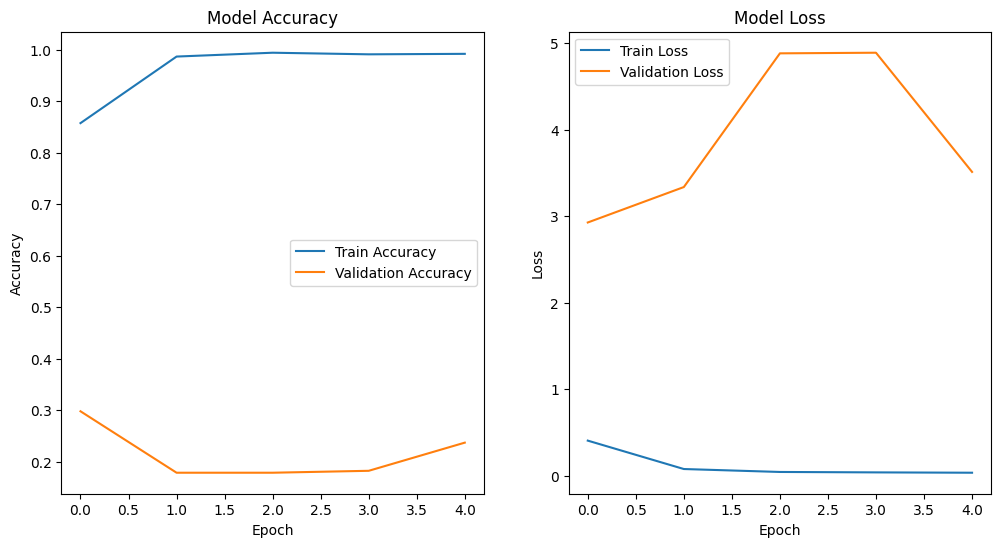

Results for Configuration 1: {'Total Training Time': 223.30317783355713, 'Memory Usage (MB)': 5547.25, 'Testing Accuracy': 0.244047611951828, 'Confusion Matrix': array([[ 69,   0,   0, 231],
       [ 16,   0,   0, 211],
       [  1,   0,   0, 299],
       [  4,   0,   0, 177]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.77      0.23      0.35       300\n           1       0.00      0.00      0.00       227\n           2       0.00      0.00      0.00       300\n           3       0.19      0.98      0.32       181\n\n    accuracy                           0.24      1008\n   macro avg       0.24      0.30      0.17      1008\nweighted avg       0.26      0.24      0.16      1008\n'}
Running Configuration 2
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Epoch 1/5
101/101 [==============================] - 57s 390ms/step - loss: 0.1169 - accuracy: 0.9602 - val_loss: 2.9906 - val_accuracy: 0.4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


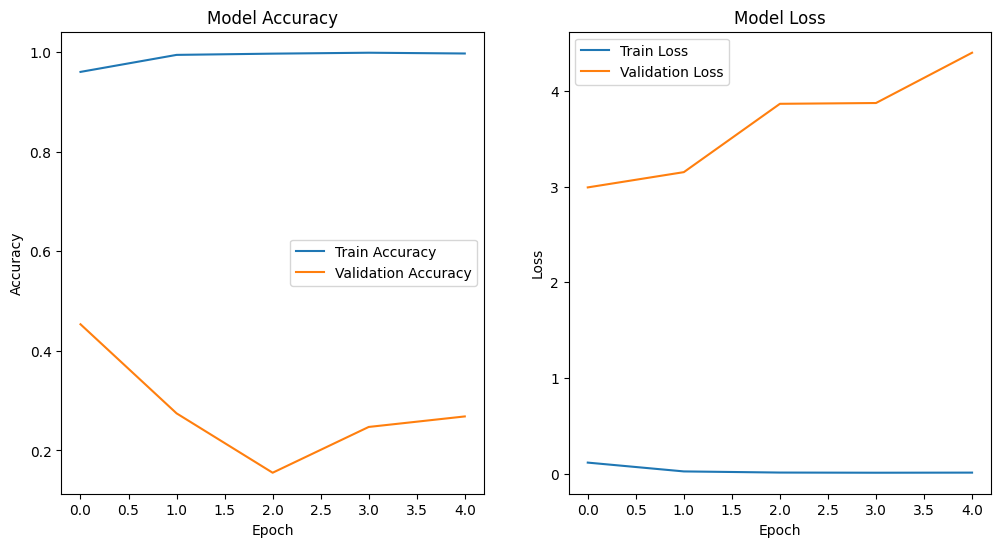

Results for Configuration 2: {'Total Training Time': 212.24216985702515, 'Memory Usage (MB)': 5712.640625, 'Testing Accuracy': 0.2648809552192688, 'Confusion Matrix': array([[ 71,   0,   0, 229],
       [  0,  24,   0, 203],
       [  0,   0,   0, 300],
       [  9,   0,   0, 172]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.89      0.24      0.37       300\n           1       1.00      0.11      0.19       227\n           2       0.00      0.00      0.00       300\n           3       0.19      0.95      0.32       181\n\n    accuracy                           0.26      1008\n   macro avg       0.52      0.32      0.22      1008\nweighted avg       0.52      0.26      0.21      1008\n'}
Running Configuration 3
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Epoch 1/5
101/101 [==============================] - 69s 385ms/step - loss: 1.1340 - accuracy: 0.6637 - val_loss: 306236192.0000 - val_

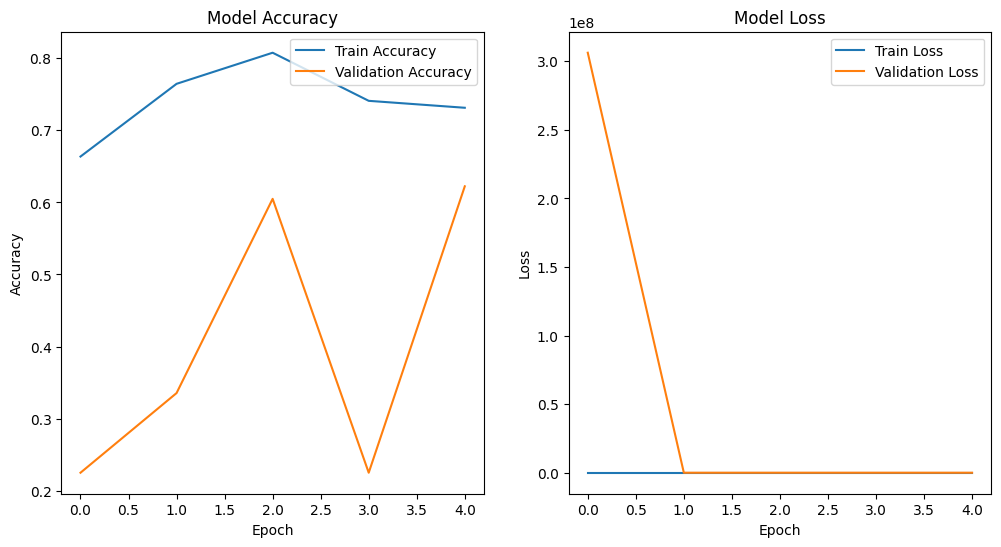

Results for Configuration 3: {'Total Training Time': 230.6729278564453, 'Memory Usage (MB)': 6301.65625, 'Testing Accuracy': 0.613095223903656, 'Confusion Matrix': array([[279,   5,   5,  11],
       [220,   5,   0,   2],
       [  0,   0, 300,   0],
       [  3,   0, 144,  34]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.56      0.93      0.70       300\n           1       0.50      0.02      0.04       227\n           2       0.67      1.00      0.80       300\n           3       0.72      0.19      0.30       181\n\n    accuracy                           0.61      1008\n   macro avg       0.61      0.53      0.46      1008\nweighted avg       0.61      0.61      0.51      1008\n'}
Running Configuration 4
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Epoch 1/5
101/101 [==============================] - 70s 384ms/step - loss: 0.6569 - accuracy: 0.7379 - val_loss: 0.6933 - val_accuracy: 0

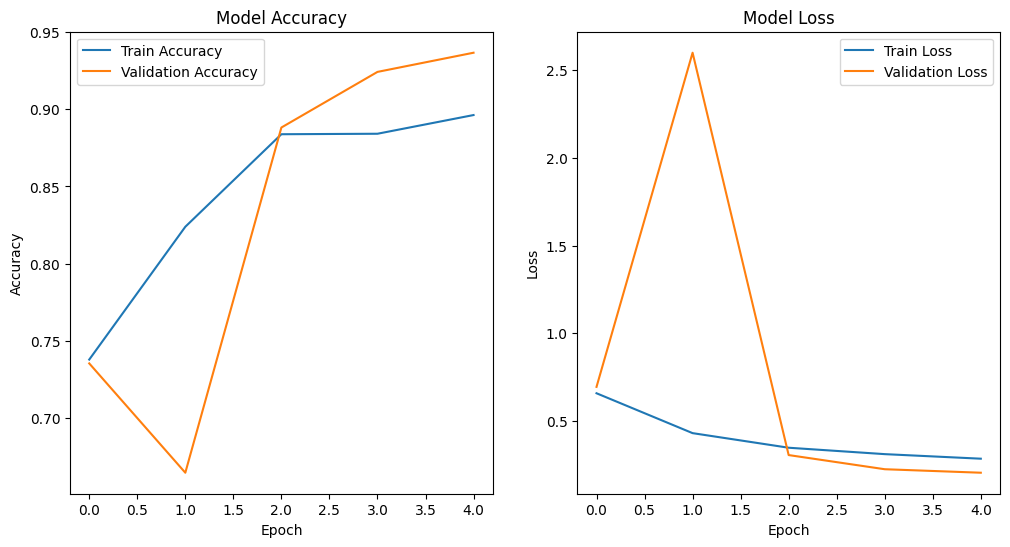

Results for Configuration 4: {'Total Training Time': 221.87107515335083, 'Memory Usage (MB)': 6885.265625, 'Testing Accuracy': 0.9166666865348816, 'Confusion Matrix': array([[277,  17,   2,   4],
       [ 10, 217,   0,   0],
       [  0,   0, 288,  12],
       [  2,   0,  37, 142]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.96      0.92      0.94       300\n           1       0.93      0.96      0.94       227\n           2       0.88      0.96      0.92       300\n           3       0.90      0.78      0.84       181\n\n    accuracy                           0.92      1008\n   macro avg       0.92      0.91      0.91      1008\nweighted avg       0.92      0.92      0.92      1008\n'}


In [ ]:
# Load pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define your data directory
data_dir = '/content/extracted_images/images'  # Ensure this is your correct path

# Configurations for training
configs = [
    {'learning_rate': 0.0001, 'optimizer': 'sgd', 'momentum': 0.9, 'dropout_rate': 0, 'num_epochs': 5},
    {'learning_rate': 0.001, 'optimizer': 'sgd', 'momentum': 0.85, 'dropout_rate': 0.2, 'num_epochs': 5},
    {'learning_rate': 0.01, 'optimizer': 'adam', 'dropout_rate': 0, 'num_epochs': 5},
    {'learning_rate': 0.001, 'optimizer': 'adam', 'dropout_rate': 0.5, 'num_epochs': 5}
]

# Execute each configuration
for i, config in enumerate(configs):
    print(f"Running Configuration {i+1}")
    results = build_and_train_model(
        resnet_model,
        learning_rate=config['learning_rate'],
        optimizer=config['optimizer'],
        momentum=config.get('momentum'),
        dropout_rate=config['dropout_rate'],
        num_epochs=config['num_epochs'],
        data_dir=data_dir
    )
    print(f"Results for Configuration {i+1}: {results}")

## GoogleNet

87910968/87910968 [==============================] - 1s 0us/step
Running Configuration 1
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Found 1008 images belonging to 4 classes.
Epoch 1/5
101/101 [==============================] - 102s 612ms/step - loss: 0.2801 - accuracy: 0.9143 - val_loss: 2.2184 - val_accuracy: 0.5565
Epoch 2/5
101/101 [==============================] - 49s 486ms/step - loss: 0.0369 - accuracy: 0.9916 - val_loss: 1.5375 - val_accuracy: 0.6646
Epoch 3/5
101/101 [==============================] - 47s 469ms/step - loss: 0.0265 - accuracy: 0.9941 - val_loss: 0.2268 - val_accuracy: 0.9342
Epoch 4/5
101/101 [==============================] - 49s 487ms/step - loss: 0.0336 - accuracy: 0.9904 - val_loss: 1.6829 - val_accuracy: 0.6050
Epoch 5/5
32/32 [==============================] - 6s 127ms/step


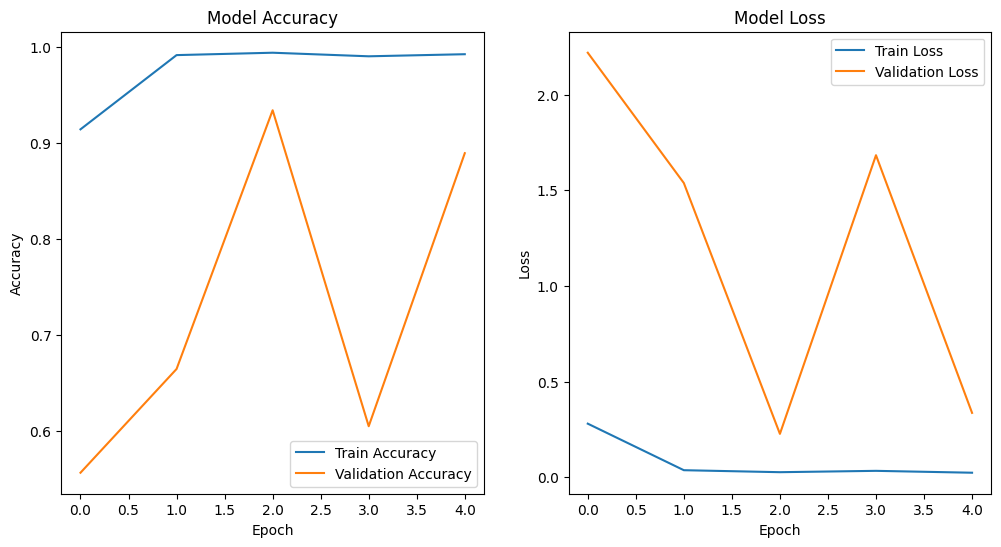

Results for Configuration 1: {'Total Training Time': 330.14074301719666, 'Testing Accuracy': 0.8621031641960144, 'Confusion Matrix': array([[118,  38,  64,  80],
       [ 79,  33,  58,  57],
       [109,  46,  81,  64],
       [ 75,  28,  41,  37]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.31      0.39      0.35       300\n           1       0.23      0.15      0.18       227\n           2       0.33      0.27      0.30       300\n           3       0.16      0.20      0.18       181\n\n    accuracy                           0.27      1008\n   macro avg       0.26      0.25      0.25      1008\nweighted avg       0.27      0.27      0.26      1008\n'}
Running Configuration 2
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Found 1008 images belonging to 4 classes.
Epoch 1/5
101/101 [==============================] - 67s 488ms/step - loss: 0.1618 - accuracy: 0.9512 - val_loss: 0.0751 - val_

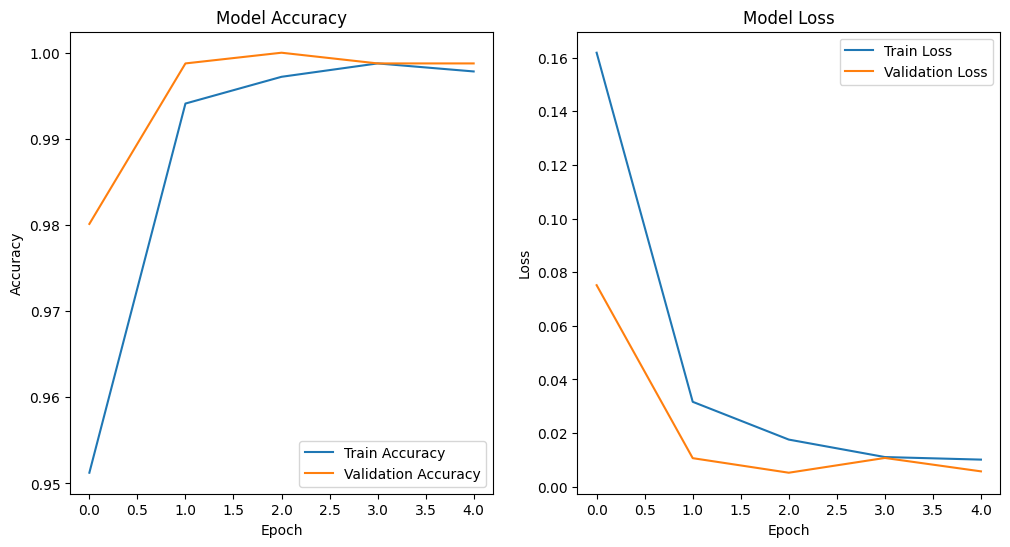

Results for Configuration 2: {'Total Training Time': 291.4672963619232, 'Testing Accuracy': 0.9990079402923584, 'Confusion Matrix': array([[90, 62, 92, 56],
       [68, 51, 73, 35],
       [92, 65, 87, 56],
       [49, 49, 48, 35]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.30      0.30      0.30       300\n           1       0.22      0.22      0.22       227\n           2       0.29      0.29      0.29       300\n           3       0.19      0.19      0.19       181\n\n    accuracy                           0.26      1008\n   macro avg       0.25      0.25      0.25      1008\nweighted avg       0.26      0.26      0.26      1008\n'}
Running Configuration 3
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Found 1008 images belonging to 4 classes.
Epoch 1/5
101/101 [==============================] - 83s 488ms/step - loss: 1.4704 - accuracy: 0.3342 - val_loss: 119667.3281 - val_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


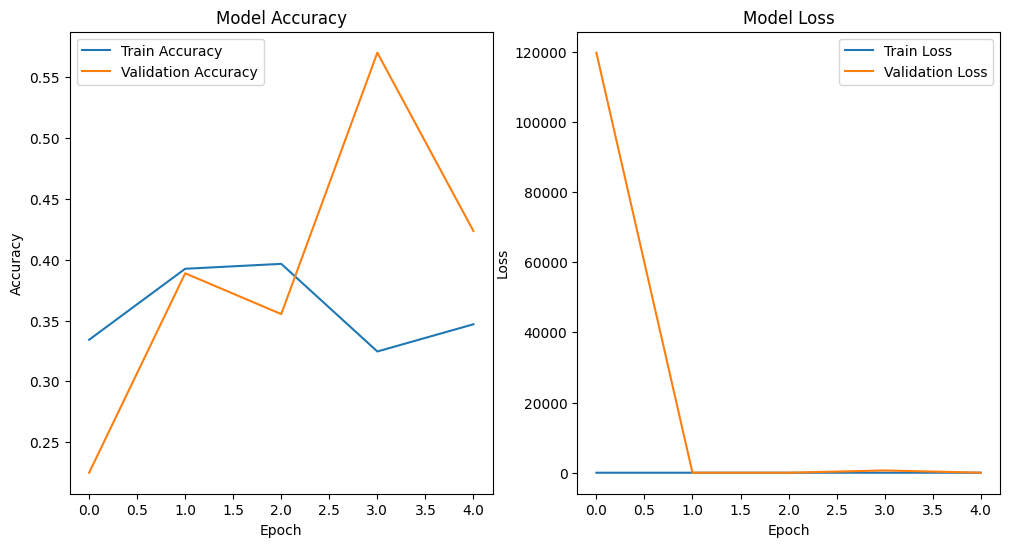

Results for Configuration 3: {'Total Training Time': 272.20454382896423, 'Testing Accuracy': 0.4295634925365448, 'Confusion Matrix': array([[ 50,   0, 250,   0],
       [ 33,   0, 194,   0],
       [ 41,   0, 259,   0],
       [ 23,   0, 158,   0]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.34      0.17      0.22       300\n           1       0.00      0.00      0.00       227\n           2       0.30      0.86      0.45       300\n           3       0.00      0.00      0.00       181\n\n    accuracy                           0.31      1008\n   macro avg       0.16      0.26      0.17      1008\nweighted avg       0.19      0.31      0.20      1008\n'}
Running Configuration 4
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Found 1008 images belonging to 4 classes.
Epoch 1/10
101/101 [==============================] - 78s 473ms/step - loss: 1.3658 - accuracy: 0.2811 - val_loss: 1.3286 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


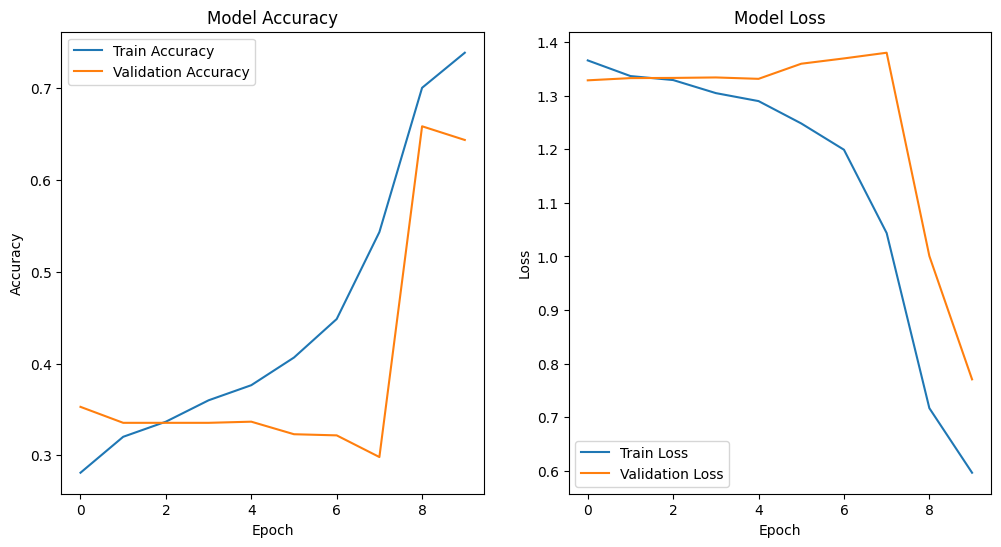

Results for Configuration 4: {'Total Training Time': 639.76398229599, 'Testing Accuracy': 0.6607142686843872, 'Confusion Matrix': array([[ 41, 115, 144,   0],
       [ 24,  88, 115,   0],
       [ 44, 114, 142,   0],
       [ 31,  69,  81,   0]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.29      0.14      0.19       300\n           1       0.23      0.39      0.29       227\n           2       0.29      0.47      0.36       300\n           3       0.00      0.00      0.00       181\n\n    accuracy                           0.27      1008\n   macro avg       0.20      0.25      0.21      1008\nweighted avg       0.23      0.27      0.23      1008\n'}


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import os
from sklearn.metrics import confusion_matrix, classification_report

def build_and_train_model(base_model, learning_rate, optimizer='adam', momentum=None, dropout_rate=0, num_epochs=10, batch_size=32, data_dir='path_to_data'):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    predictions = Dense(4, activation='softmax')(x)  # Adjusted to 4 classes
    model = Model(inputs=base_model.input, outputs=predictions)

    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=momentum)
    else:
        opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    train_datagen = ImageDataGenerator(rescale=1./255)
    valid_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=(299, 299),  # InceptionV3 standard input size
        batch_size=batch_size,
        class_mode='categorical')

    valid_gen = valid_datagen.flow_from_directory(
        os.path.join(data_dir, 'validation'),
        target_size=(299, 299),  # InceptionV3 standard input size
        batch_size=batch_size,
        class_mode='categorical')

    test_gen = test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=(299, 299),  # InceptionV3 standard input size
        batch_size=batch_size,
        class_mode='categorical')

    start_time = time.time()
    history = model.fit(train_gen, epochs=num_epochs, validation_data=valid_gen)
    end_time = time.time()

    results = model.evaluate(test_gen)
    predictions = model.predict(test_gen)
    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = test_gen.classes
    cm = confusion_matrix(true_classes, predicted_classes)
    cr = classification_report(true_classes, predicted_classes)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return {
        "Total Training Time": end_time - start_time,
        "Testing Accuracy": results[1],
        "Confusion Matrix": cm,
        "Classification Report": cr
    }

# Load pre-trained InceptionV3 model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Define your data directory
data_dir = '/content/extracted_images/images'  # Ensure this is your correct path

# Configurations for training
configs = [
    {'learning_rate': 0.001, 'optimizer': 'sgd', 'momentum': 0.9, 'dropout_rate': 0, 'num_epochs': 5},
    {'learning_rate': 0.001, 'optimizer': 'sgd', 'momentum': 0.85, 'dropout_rate': 0.2, 'num_epochs': 5},
    {'learning_rate': 0.01, 'optimizer': 'adam', 'dropout_rate': 0, 'num_epochs': 5},
    {'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout_rate': 0.5, 'num_epochs': 10}
]

# Execute each configuration
for i, config in enumerate(configs):
    print(f"Running Configuration {i+1}")
    results = build_and_train_model(
        inception_model,
        learning_rate=config['learning_rate'],
        optimizer=config['optimizer'],
        momentum=config.get('momentum'),
        dropout_rate=config['dropout_rate'],
        num_epochs=config['num_epochs'],
        data_dir=data_dir
    )
    print(f"Results for Configuration {i+1}: {results}")


## VGG16

58889256/58889256 [==============================] - 0s 0us/step
Running Configuration 1
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Found 1008 images belonging to 4 classes.
Epoch 1/5
101/101 [==============================] - 86s 600ms/step - loss: 0.7866 - accuracy: 0.6348 - val_loss: 0.4500 - val_accuracy: 0.7913
Epoch 2/5
101/101 [==============================] - 45s 443ms/step - loss: 0.4209 - accuracy: 0.8028 - val_loss: 0.2912 - val_accuracy: 0.8410
Epoch 3/5
101/101 [==============================] - 46s 460ms/step - loss: 0.4382 - accuracy: 0.7901 - val_loss: 0.2024 - val_accuracy: 0.9466
Epoch 4/5
101/101 [==============================] - 45s 442ms/step - loss: 0.1950 - accuracy: 0.9199 - val_loss: 0.1905 - val_accuracy: 0.9292
Epoch 5/5
32/32 [==============================] - 4s 126ms/step


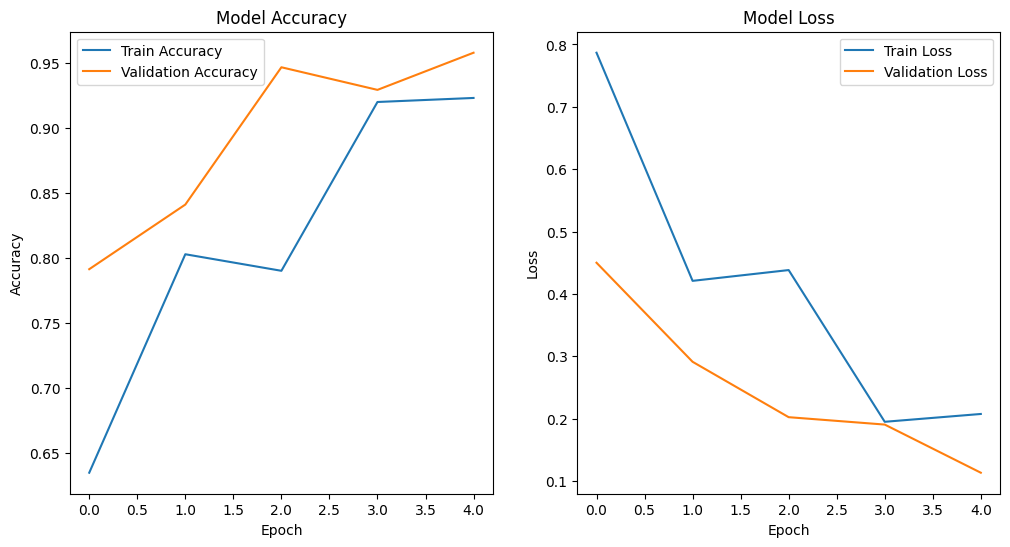

Results for Configuration 1: {'Total Training Time': 304.26337146759033, 'Memory Usage (MB)': 3726.734375, 'Testing Accuracy': 0.9553571343421936, 'Confusion Matrix': array([[ 79,  79,  92,  50],
       [ 64,  52,  70,  41],
       [ 90,  63, 101,  46],
       [ 46,  52,  56,  27]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.28      0.26      0.27       300\n           1       0.21      0.23      0.22       227\n           2       0.32      0.34      0.33       300\n           3       0.16      0.15      0.16       181\n\n    accuracy                           0.26      1008\n   macro avg       0.24      0.24      0.24      1008\nweighted avg       0.26      0.26      0.26      1008\n'}
Running Configuration 2
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Found 1008 images belonging to 4 classes.
Epoch 1/5
101/101 [==============================] - 47s 441ms/step - loss: 0.2495 - accuracy

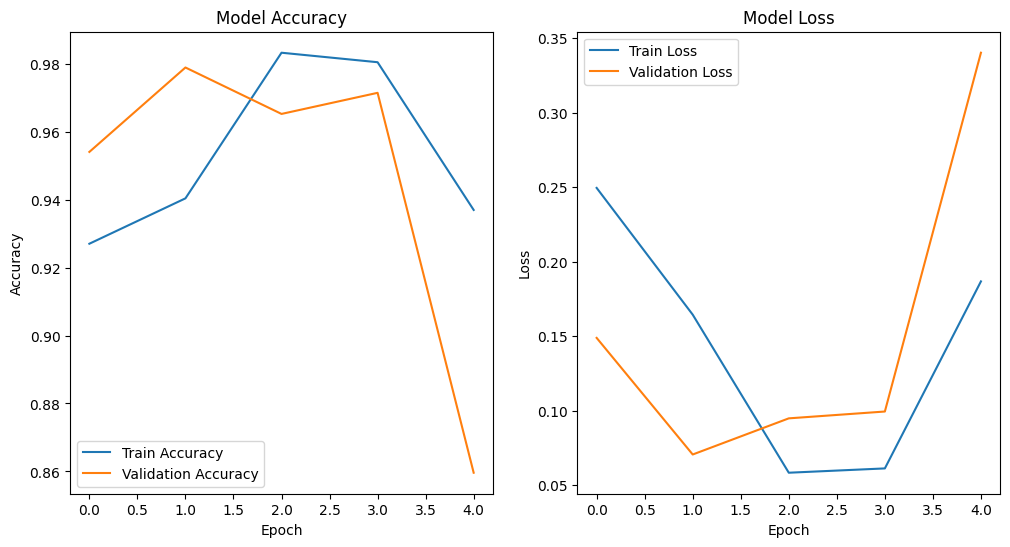

Results for Configuration 2: {'Total Training Time': 299.8013536930084, 'Memory Usage (MB)': 3807.578125, 'Testing Accuracy': 0.8521825671195984, 'Confusion Matrix': array([[69, 83, 61, 87],
       [57, 58, 38, 74],
       [96, 60, 53, 91],
       [54, 45, 30, 52]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.25      0.23      0.24       300\n           1       0.24      0.26      0.25       227\n           2       0.29      0.18      0.22       300\n           3       0.17      0.29      0.21       181\n\n    accuracy                           0.23      1008\n   macro avg       0.24      0.24      0.23      1008\nweighted avg       0.24      0.23      0.23      1008\n'}
Running Configuration 3
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Found 1008 images belonging to 4 classes.
Epoch 1/5
101/101 [==============================] - 47s 418ms/step - loss: 50301884.0000 - accuracy: 0.2609 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


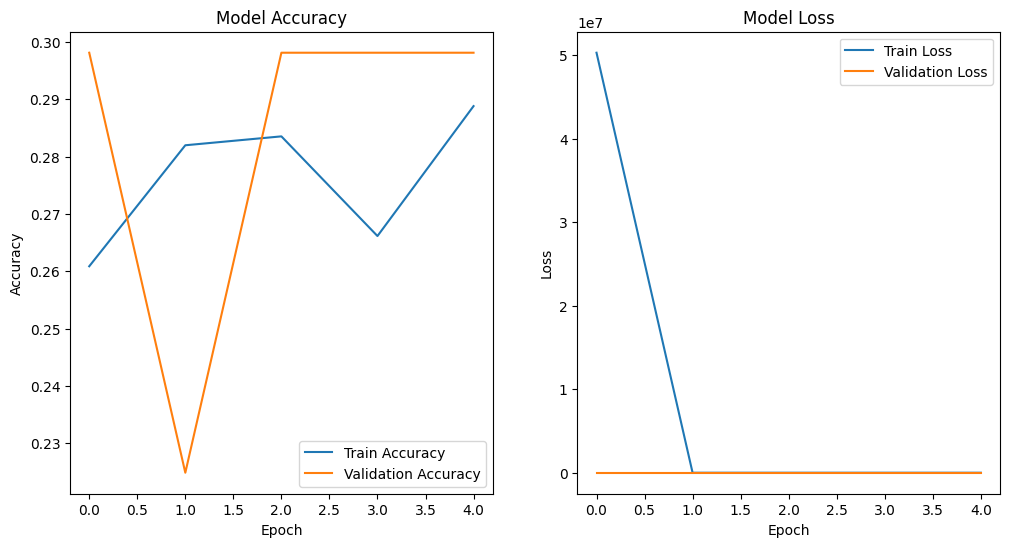

Results for Configuration 3: {'Total Training Time': 253.91717839241028, 'Memory Usage (MB)': 3759.27734375, 'Testing Accuracy': 0.2976190447807312, 'Confusion Matrix': array([[  0,   0, 300,   0],
       [  0,   0, 227,   0],
       [  0,   0, 300,   0],
       [  0,   0, 181,   0]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       300\n           1       0.00      0.00      0.00       227\n           2       0.30      1.00      0.46       300\n           3       0.00      0.00      0.00       181\n\n    accuracy                           0.30      1008\n   macro avg       0.07      0.25      0.11      1008\nweighted avg       0.09      0.30      0.14      1008\n'}
Running Configuration 4
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Found 1008 images belonging to 4 classes.
Epoch 1/10
101/101 [==============================] - 45s 415ms/step - loss: 1.5287 - accur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


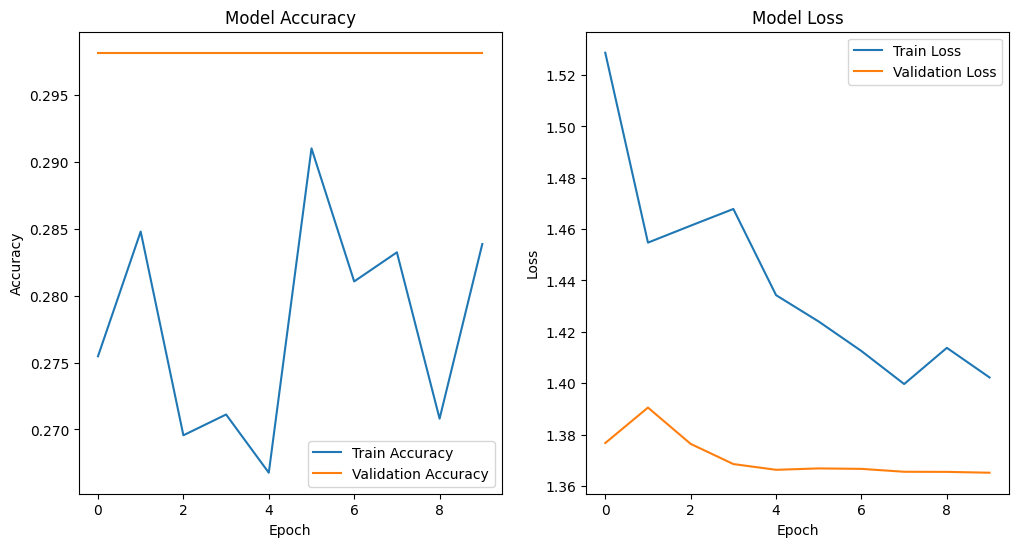

Results for Configuration 4: {'Total Training Time': 457.2598023414612, 'Memory Usage (MB)': 3729.59375, 'Testing Accuracy': 0.2976190447807312, 'Confusion Matrix': array([[  0,   0, 300,   0],
       [  0,   0, 227,   0],
       [  0,   0, 300,   0],
       [  0,   0, 181,   0]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       300\n           1       0.00      0.00      0.00       227\n           2       0.30      1.00      0.46       300\n           3       0.00      0.00      0.00       181\n\n    accuracy                           0.30      1008\n   macro avg       0.07      0.25      0.11      1008\nweighted avg       0.09      0.30      0.14      1008\n'}


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import os
from sklearn.metrics import confusion_matrix, classification_report

def build_and_train_model(base_model, learning_rate, optimizer='adam', momentum=None, dropout_rate=0, num_epochs=10, batch_size=32, data_dir='path_to_data'):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    predictions = Dense(4, activation='softmax')(x)  # Adjusted to 4 classes
    model = Model(inputs=base_model.input, outputs=predictions)

    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=momentum)
    else:
        opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    train_datagen = ImageDataGenerator(rescale=1./255)
    valid_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=(224, 224),  # VGG16 default input size
        batch_size=batch_size,
        class_mode='categorical')

    valid_gen = valid_datagen.flow_from_directory(
        os.path.join(data_dir, 'validation'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

    test_gen = test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

    start_time = time.time()
    history = model.fit(train_gen, epochs=num_epochs, validation_data=valid_gen)
    end_time = time.time()

    results = model.evaluate(test_gen)
    predictions = model.predict(test_gen)
    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = test_gen.classes
    cm = confusion_matrix(true_classes, predicted_classes)
    cr = classification_report(true_classes, predicted_classes)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Calculate memory usage
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss / (1024 ** 2)  # in MB

    return {
        "Total Training Time": end_time - start_time,
        "Memory Usage (MB)": memory_usage,
        "Testing Accuracy": results[1],
        "Confusion Matrix": cm,
        "Classification Report": cr
    }

# Load pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define your data directory
data_dir = '/content/extracted_images/images'  # Ensure this is your correct path

# Configurations for training
configs = [
    {'learning_rate': 0.001, 'optimizer': 'sgd', 'momentum': 0.9, 'dropout_rate': 0, 'num_epochs': 5},
    {'learning_rate': 0.001, 'optimizer': 'sgd', 'momentum': 0.85, 'dropout_rate': 0.2, 'num_epochs': 5},
    {'learning_rate': 0.01, 'optimizer': 'adam', 'dropout_rate': 0, 'num_epochs': 5},
    {'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout_rate': 0.5, 'num_epochs': 10}
]

# Execute each configuration
for i, config in enumerate(configs):
    print(f"Running Configuration {i+1}")
    results = build_and_train_model(
        base_model=vgg_model,
        learning_rate=config['learning_rate'],
        optimizer=config['optimizer'],
        momentum=config.get('momentum'),
        dropout_rate=config['dropout_rate'],
        num_epochs=config['num_epochs'],
        data_dir=data_dir
    )
    print(f"Results for Configuration {i+1}: {results}")


## AlexNet_v.2

Running Configuration 1
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Found 1008 images belonging to 4 classes.
Epoch 1/5
101/101 [==============================] - 12s 96ms/step - loss: 1.2337 - accuracy: 0.3969 - val_loss: 0.9482 - val_accuracy: 0.6062
Epoch 2/5
101/101 [==============================] - 7s 65ms/step - loss: 0.6968 - accuracy: 0.6960 - val_loss: 0.5410 - val_accuracy: 0.7453
Epoch 3/5
101/101 [==============================] - 8s 78ms/step - loss: 0.5757 - accuracy: 0.7280 - val_loss: 0.4688 - val_accuracy: 0.7739
Epoch 4/5
101/101 [==============================] - 7s 69ms/step - loss: 0.4984 - accuracy: 0.7624 - val_loss: 0.5681 - val_accuracy: 0.7416
Epoch 5/5
32/32 [==============================] - 2s 46ms/step


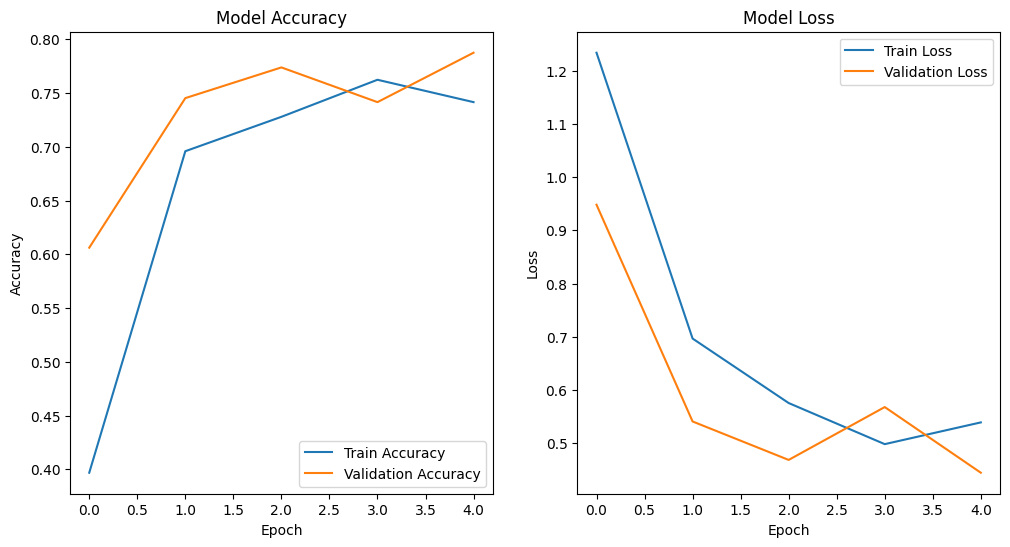

Results for Configuration 1: {'Total Training Time': 41.63497757911682, 'Memory Usage (MB)': 3965.66015625, 'Testing Accuracy': 0.7658730149269104, 'Confusion Matrix': array([[ 96,  70, 122,  12],
       [ 70,  45, 100,  12],
       [ 94,  54, 141,  11],
       [ 66,  30,  80,   5]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.29      0.32      0.31       300\n           1       0.23      0.20      0.21       227\n           2       0.32      0.47      0.38       300\n           3       0.12      0.03      0.05       181\n\n    accuracy                           0.28      1008\n   macro avg       0.24      0.25      0.24      1008\nweighted avg       0.26      0.28      0.26      1008\n'}
Running Configuration 2
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Found 1008 images belonging to 4 classes.
Epoch 1/5
101/101 [==============================] - 10s 84ms/step - loss: 1.2443 - accuracy

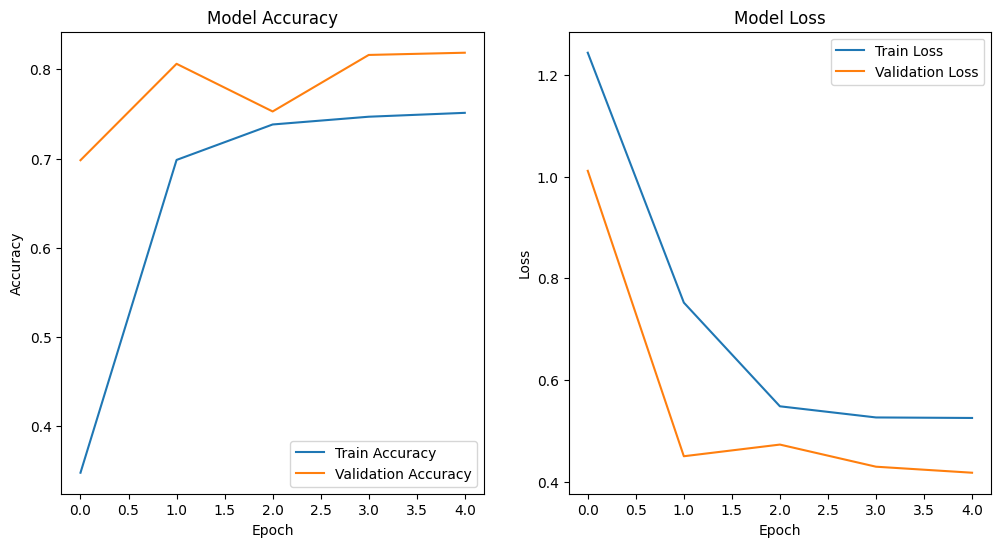

Results for Configuration 2: {'Total Training Time': 41.75547409057617, 'Memory Usage (MB)': 3975.3671875, 'Testing Accuracy': 0.795634925365448, 'Confusion Matrix': array([[ 91,  86, 114,   9],
       [ 63,  51, 103,  10],
       [ 69,  70, 148,  13],
       [ 58,  37,  80,   6]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.32      0.30      0.31       300\n           1       0.21      0.22      0.22       227\n           2       0.33      0.49      0.40       300\n           3       0.16      0.03      0.05       181\n\n    accuracy                           0.29      1008\n   macro avg       0.26      0.26      0.25      1008\nweighted avg       0.27      0.29      0.27      1008\n'}
Running Configuration 3
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Found 1008 images belonging to 4 classes.
Epoch 1/5
101/101 [==============================] - 13s 92ms/step - loss: 34574.6250 - accura

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


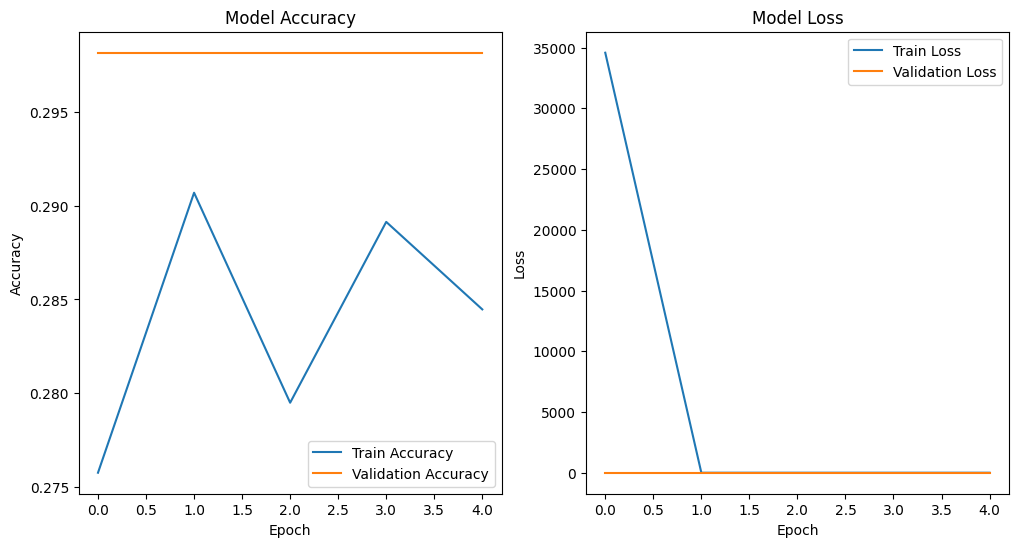

Results for Configuration 3: {'Total Training Time': 43.91242551803589, 'Memory Usage (MB)': 4052.65234375, 'Testing Accuracy': 0.2976190447807312, 'Confusion Matrix': array([[300,   0,   0,   0],
       [227,   0,   0,   0],
       [300,   0,   0,   0],
       [181,   0,   0,   0]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.30      1.00      0.46       300\n           1       0.00      0.00      0.00       227\n           2       0.00      0.00      0.00       300\n           3       0.00      0.00      0.00       181\n\n    accuracy                           0.30      1008\n   macro avg       0.07      0.25      0.11      1008\nweighted avg       0.09      0.30      0.14      1008\n'}
Running Configuration 4
Found 3220 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Found 1008 images belonging to 4 classes.
Epoch 1/10
101/101 [==============================] - 10s 73ms/step - loss: 0.6923 - accurac

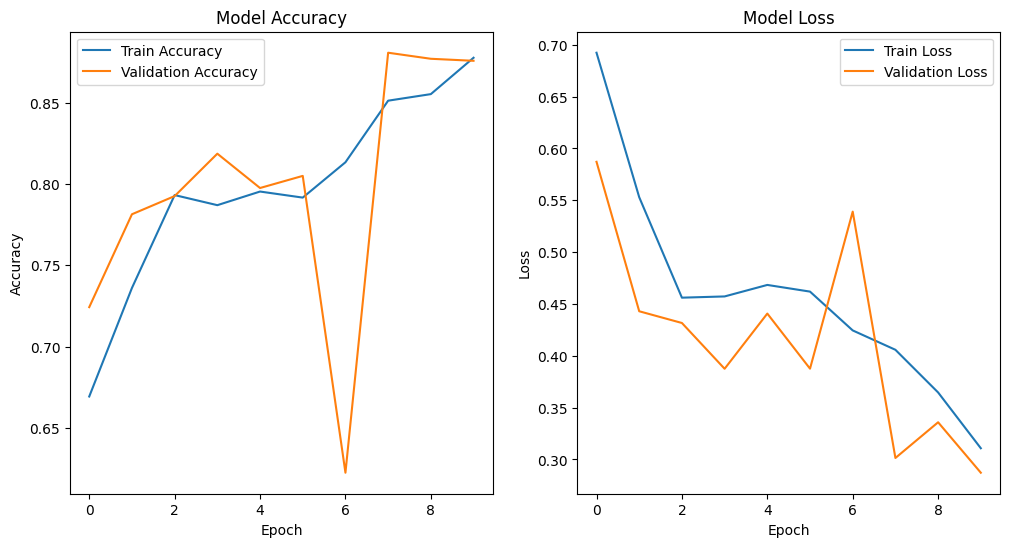

Results for Configuration 4: {'Total Training Time': 93.82330131530762, 'Memory Usage (MB)': 4094.87109375, 'Testing Accuracy': 0.863095223903656, 'Confusion Matrix': array([[89, 70, 96, 45],
       [63, 59, 67, 38],
       [73, 77, 96, 54],
       [54, 39, 61, 27]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.32      0.30      0.31       300\n           1       0.24      0.26      0.25       227\n           2       0.30      0.32      0.31       300\n           3       0.16      0.15      0.16       181\n\n    accuracy                           0.27      1008\n   macro avg       0.26      0.26      0.26      1008\nweighted avg       0.27      0.27      0.27      1008\n'}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import os
from sklearn.metrics import confusion_matrix, classification_report

def build_alexnet_model(input_shape, num_classes, dropout_rate=0.5):
    model = Sequential([
        Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(dropout_rate),
        Dense(4096, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    return model

def build_and_train_model(learning_rate, optimizer='adam', momentum=None, dropout_rate=0.5, num_epochs=10, batch_size=32, data_dir='path_to_data'):
    input_shape = (227, 227, 3)  # AlexNet default input size
    num_classes = 4  # Adjust to the number of classes in your dataset

    model = build_alexnet_model(input_shape, num_classes, dropout_rate)

    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=momentum)
    else:
        opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    train_datagen = ImageDataGenerator(rescale=1./255)
    valid_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=(227, 227),  # AlexNet default input size
        batch_size=batch_size,
        class_mode='categorical')

    valid_gen = valid_datagen.flow_from_directory(
        os.path.join(data_dir, 'validation'),
        target_size=(227, 227),
        batch_size=batch_size,
        class_mode='categorical')

    test_gen = test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=(227, 227),
        batch_size=batch_size,
        class_mode='categorical')

    start_time = time.time()
    history = model.fit(train_gen, epochs=num_epochs, validation_data=valid_gen)
    end_time = time.time()

    results = model.evaluate(test_gen)
    predictions = model.predict(test_gen)
    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = test_gen.classes
    cm = confusion_matrix(true_classes, predicted_classes)
    cr = classification_report(true_classes, predicted_classes)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Calculate memory usage
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss / (1024 ** 2)  # in MB

    return {
        "Total Training Time": end_time - start_time,
        "Memory Usage (MB)": memory_usage,
        "Testing Accuracy": results[1],
        "Confusion Matrix": cm,
        "Classification Report": cr
    }

# Define your data directory
data_dir = '/content/extracted_images/images'  # Ensure this is your correct path

# Configurations for training
configs = [
    {'learning_rate': 0.001, 'optimizer': 'sgd', 'momentum': 0.9, 'dropout_rate': 0.5, 'num_epochs': 5},
    {'learning_rate': 0.001, 'optimizer': 'sgd', 'momentum': 0.85, 'dropout_rate': 0.5, 'num_epochs': 5},
    {'learning_rate': 0.01, 'optimizer': 'adam', 'dropout_rate': 0.5, 'num_epochs': 5},
    {'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout_rate': 0.5, 'num_epochs': 10}
]

# Execute each configuration
for i, config in enumerate(configs):
    print(f"Running Configuration {i+1}")
    results = build_and_train_model(
        learning_rate=config['learning_rate'],
        optimizer=config['optimizer'],
        momentum=config.get('momentum'),
        dropout_rate=config['dropout_rate'],
        num_epochs=config['num_epochs'],
        data_dir=data_dir
    )
    print(f"Results for Configuration {i+1}: {results}")